### Predicting Residential Housing Prices

**Problem definition: **Predict the final sales price of residential houses in Ames, Iowa.  By analyzing various variables/features of residential real estate and using those features in different modelling approaches, the challenge is to build a predictive model of final sales price.  The goal is to use advanced regression forecasting techniques to make the best possible prediction of house prices.

**Potential clients: **This analysis is a practical application of machine learning techniques to better understand the dynamics of the residential real estate market.  Effective prediction models of housing prices would be useful for mortgage lending firms in primary mortgage origination, banks and financial services firms active in securitizing mortgages, and government sponsored enterprises such as the Federal National Mortgage Association and the Federal Home Loan Mortgage Corporation that create secondary markets for these securities.

**Description of data set and cleaning/wrangling steps: **The Ames Housing dataset was retrieved from [kaggle]( https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The dataset represents residential properties in Ames, Iowa from 2006 to 2010. There is a train and a test file. The train file has 1460 observations and the test file has 1459 observations. Both datasets contain 79 explanatory variables composed of 46 categorical and 33 continuous variables that describe house features such as neighborhood, square footage, number of full bathrooms, etc. The train file contains the target variable, *SalePrice*, which is what will be predicted in the test set. There is also a unique ID for each house sold, but were not used in fitting the models.

General steps in data cleaning and EDA are:
* Separating the explanatory variables into numeric features and categorical features
* Conducting exploratory data analysis of the numeric features
    * Display the highest and lowest correlations with the *SalePrice* target variable
    * Exploratory graphs of certain features against the target variable
* EDA of categorical features to include a ranked ANOVA score to identify the most influential features as well as exploratory graphs of the categorical data
* Transforming the target variable *SalePrice* to log(1 + *SalePrice*) i.e. *SalePriceLog*
* Removal of outliers for the *GrLivArea* feature transformation of skewed numeric features to log1p(*feature*)
* Filling in missing data and imputing missing values for both numeric and categorical features
* Converting categorical data to ordinal values for the purpose of removing Near Zero Variance features
* Creation of dummy variables for the remaining categorical features

The EDA and data cleaning code is listed in detail below.

**Other potential datasets: **A residential real estate dataset similar to the Ames Housing data is the often cited Boston Housing dataset.  Additionally, it's likely that firms and banks involved in mortgage origination and securitization, or online real estate database companies like Zillow have access to robust residential real estate datasets, but these are proprietary and therefore not publicly available.

**Initial findings: **The EDA and simple linear regressions seem to indicate that the continuous variable above-ground square feet *(GrLivArea)* and the logistic variables neighborhood location *(Neighborhood)* and overall housing condition *(OverallCond)*

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings

In [2]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Dataset EDA

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# columns with missing values
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [7]:
# missing value counts
miss_vals = train.isnull().sum() / len(train)
miss_vals = miss_vals[miss_vals > 0]
miss_vals.sort_values(ascending=False, inplace=True)
miss_vals

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

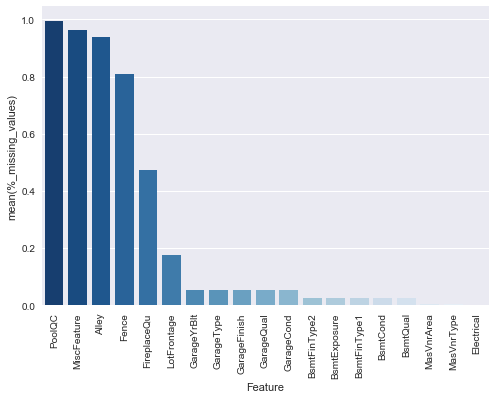

In [8]:
# plotting missing values
miss_vals = pd.DataFrame(miss_vals)
miss_vals.columns = ['%_missing_values']
miss_vals.index.names = ['Feature']
miss_vals['Feature'] = miss_vals.index

sns.set(style='darkgrid')
sns.barplot(x='Feature', y='%_missing_values', data=miss_vals, palette=sns.color_palette("Blues_r", 19))
plt.xticks(rotation=90)
sns.plt.show()

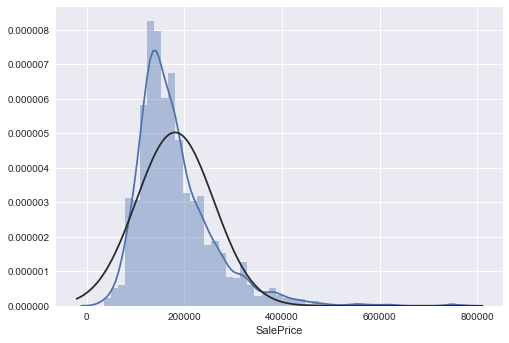

In [9]:
# distribution plot of target vaiable SalePrice
sns.distplot(train.SalePrice, fit=norm)
plt.show()

In [10]:
print('Skew of SalePrice: ', train.SalePrice.skew())

Skew of SalePrice:  1.88287575977


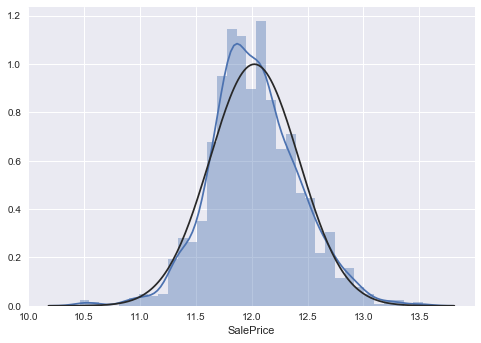

In [11]:
# transform the target variable SalePrice
SalePriceLog = np.log1p(train.SalePrice)
sns.distplot(SalePriceLog, fit=norm)
plt.show()

In [12]:
print('Skew of log1p(SalePrice): ', SalePriceLog.skew())

Skew of log1p(SalePrice):  0.121346619897


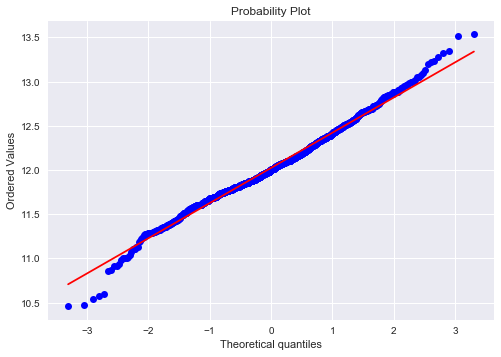

In [13]:
fig = plt.figure()
resid = stats.probplot(SalePriceLog, plot=plt)
plt.show()

In [14]:
# separate variables into numeric and categorical data frames
num_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print('Numeric columns: ', num_data.shape[1])
print('Categorical columns: ', cat_data.shape[1])

Numeric columns:  38
Categorical columns:  43


In [15]:
del num_data['Id']

#### Numerical data EDA

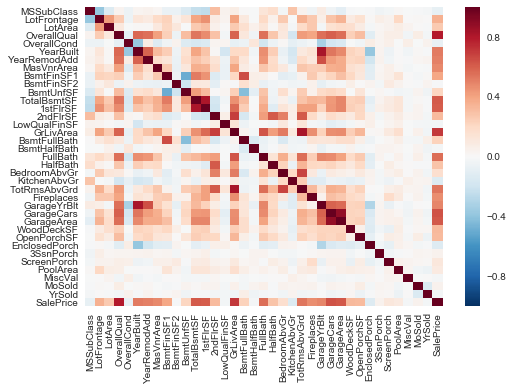

In [16]:
# correlation of numeric data
corr = num_data.corr()
sns.heatmap(corr)
plt.show()

In [17]:
# highest positively and lowest negatively correlated variables with target variable SalePrice
print(corr.SalePrice.sort_values(ascending=False)[1:16])
print('---------------------------------------')
print(corr.SalePrice.sort_values(ascending=False)[-10:])

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
Name: SalePrice, dtype: float64
---------------------------------------
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


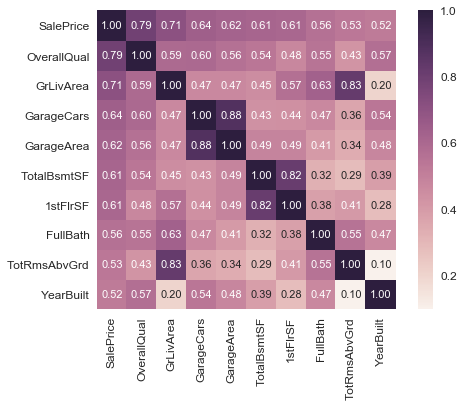

In [18]:
# SalePrice correlation matrix
k = 10 # number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice').index
cm = np.corrcoef(num_data[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [19]:
train.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [20]:
# median SalePrice by OverallQual
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot.sort_values(by='SalePrice', ascending=False)

,SalePrice
OverallQual,
10,432390
9,345000
8,269750
7,200141
6,160000
5,133000
4,108000
3,86250
2,60000


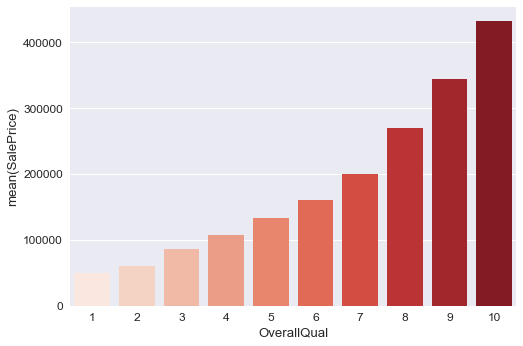

In [21]:
sns.barplot(x=pivot.index, y='SalePrice', data=pivot, palette=sns.color_palette("Reds", 10))
plt.show()

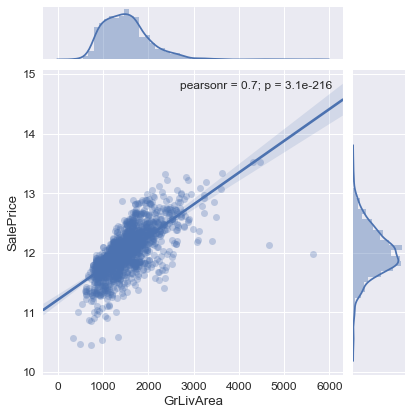

In [22]:
# jointplot of GrLivArea and SalePrice
sns.jointplot(x=train.GrLivArea, y=np.log(train.SalePrice), kind='reg', scatter_kws={'alpha':0.3})
plt.show()

#### Categorical data EDA

In [23]:
# categorical data
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [24]:
cat_data.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [25]:
KQ_pivot = train.pivot_table(index='KitchenQual', values='SalePrice', aggfunc=np.median)
KQ_pivot.sort_values(by='SalePrice', ascending=False)

,SalePrice
KitchenQual,
Ex,316750
Gd,201400
TA,137000
Fa,115000


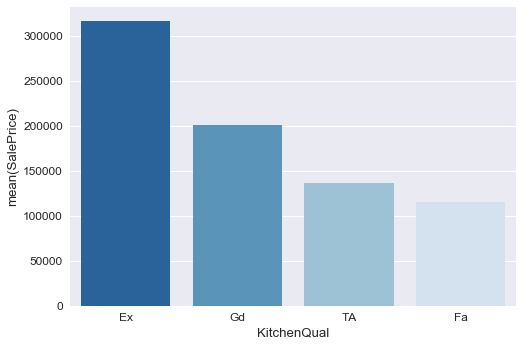

In [26]:
sns.barplot(x=KQ_pivot.index, y='SalePrice', data=KQ_pivot, order=['Ex', 'Gd', 'TA','Fa'], 
            palette=sns.color_palette("Blues_r", 4))
plt.show()

In [27]:
# ANOVA for categorical variables: p-values ranked score
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(df):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

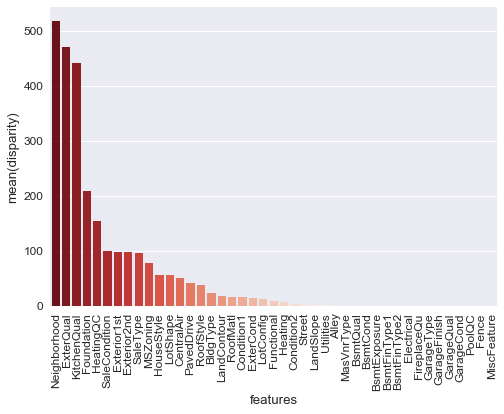

In [28]:
warnings.simplefilter('ignore')

cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data)
k['disparity'] = np.log(1./k['pval'].values)
sns.barplot(x='features', y='disparity', data=k, palette=sns.color_palette("Reds_r", 27))
plt.xticks(rotation=90)
plt.show()

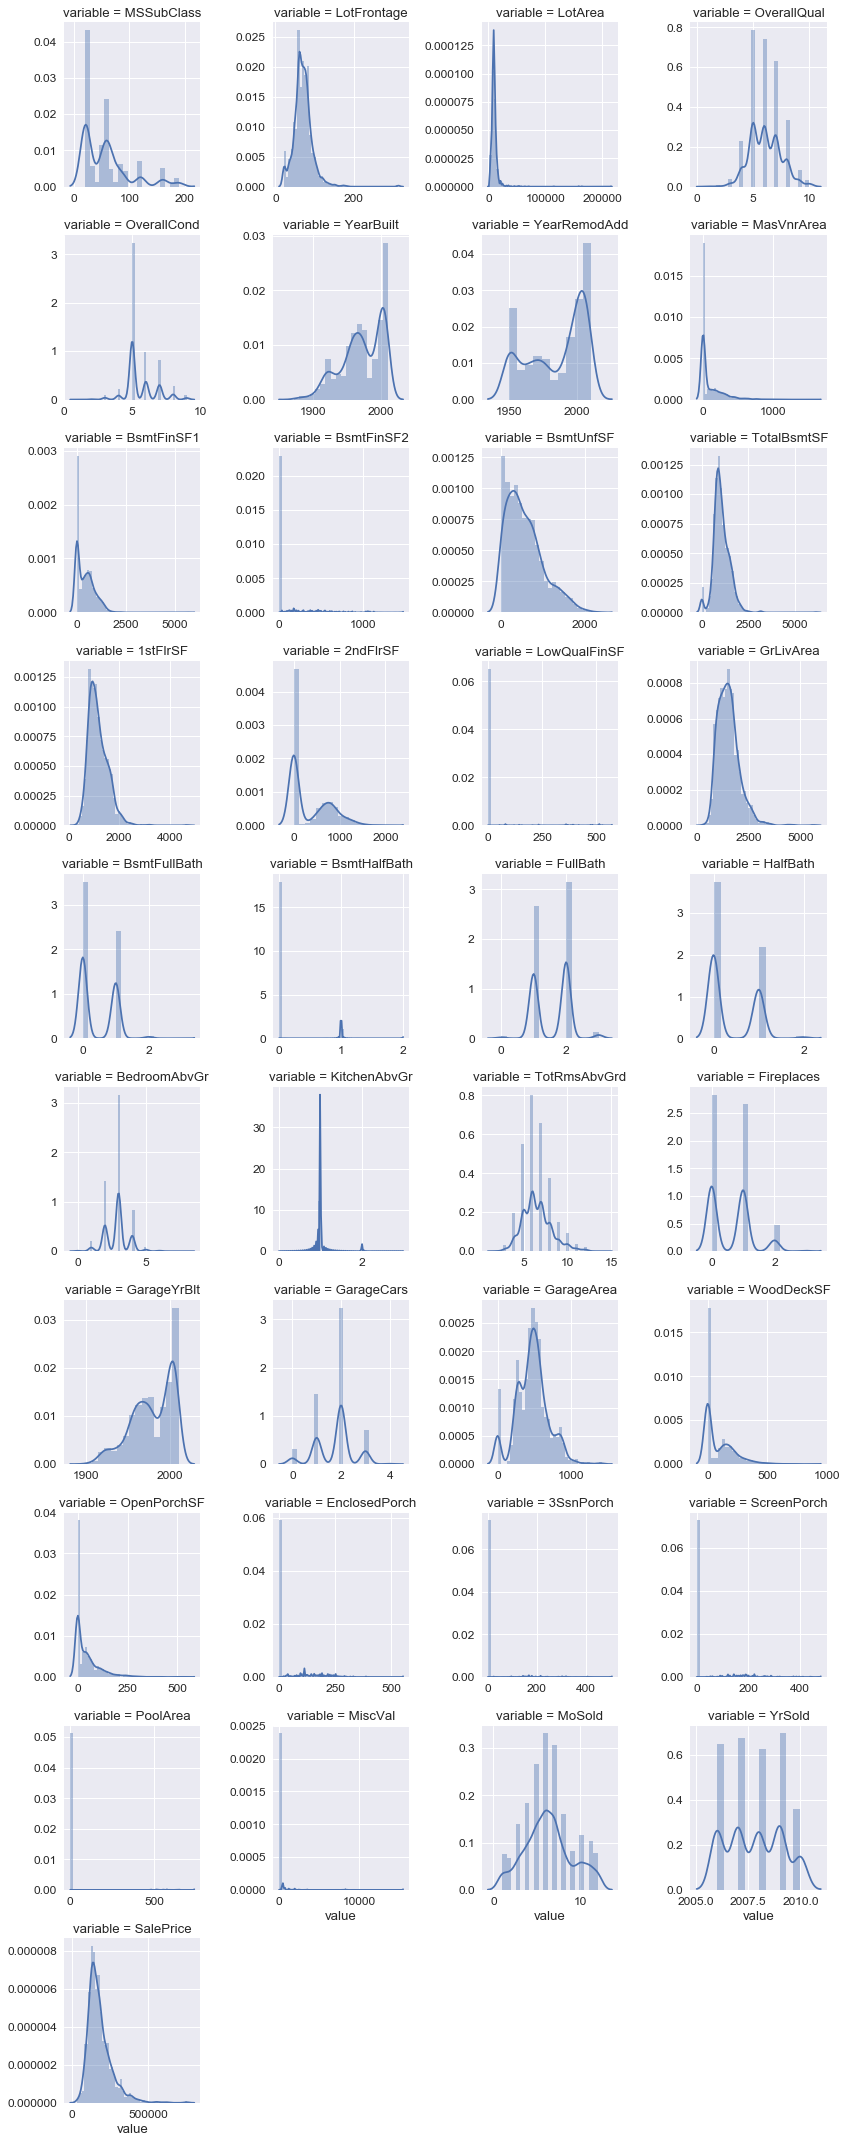

In [29]:
# distribution plots for numerical variables
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(frame=train, value_vars=num)
n1 = sns.FacetGrid(data=nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(sns.distplot, 'value')
n1
plt.show()

#### Tranform target variable SalePrice

In [30]:
# transform target variable SalePrice to log(1 + SalePrice)
train['SalePriceLog'] = np.log1p(train.SalePrice)

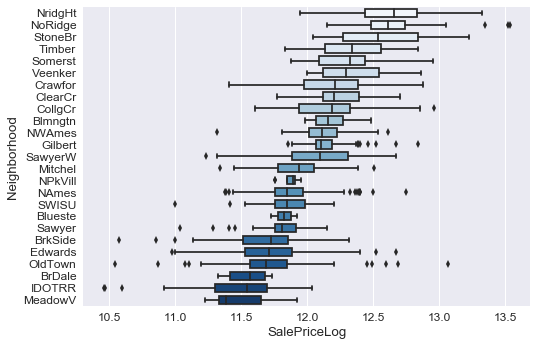

In [31]:
ranks = train.groupby('Neighborhood')['SalePriceLog'].median().fillna(0).sort_values(ascending=False).index

sns.boxplot(train.SalePriceLog, train.Neighborhood, order=ranks, palette=sns.color_palette('Blues', 25), 
            width=0.7)
plt.show()

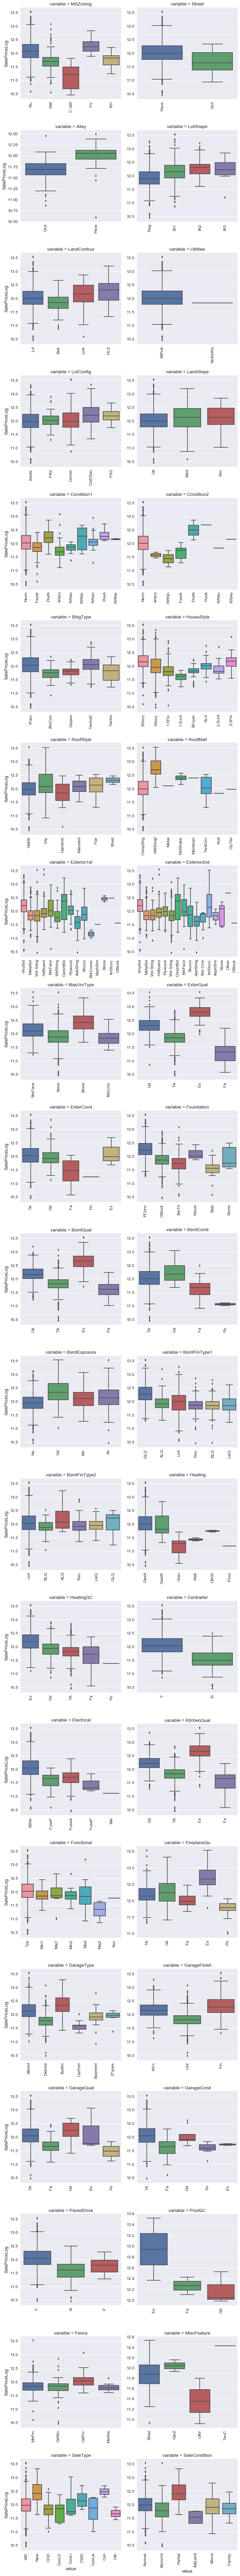

In [32]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)
    
cat_plt = [f for f in train.columns if train.dtypes[f] == 'object']
cat_plt.remove('Neighborhood')

p = pd.melt(frame=train, id_vars='SalePriceLog', value_vars=cat_plt)
p1 = sns.FacetGrid(data=p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
p1 = p1.map(boxplot, 'value', 'SalePriceLog')
p1
plt.show()

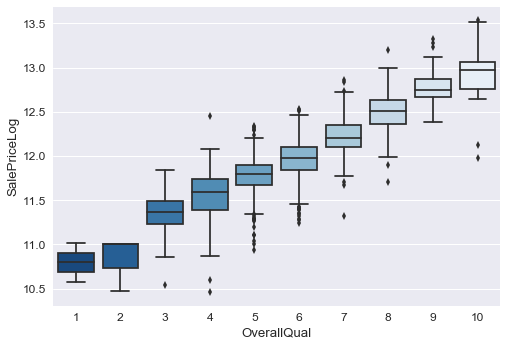

In [33]:
sns.boxplot(train.OverallQual, train.SalePriceLog, palette=sns.color_palette("Blues_r", 10))
plt.show()

#### Remove outliers in GrLivArea

In [34]:
train.GrLivArea.sort_values(ascending=False)[:2]

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [35]:
train = train.drop(train[train.GrLivArea >= 4676].index)

In [36]:
train.GrLivArea.sort_values(ascending=False)[:2]

1182    4476
691     4316
Name: GrLivArea, dtype: int64

#### Combine Data

In [37]:
# combine train and test sets for data preprocessing purposes
alldata = pd.concat((train.loc[:, 'MSSubClass':], test.loc[:, 'MSSubClass':]))
alldata.shape

(2917, 81)

#### Transform skewed variables

In [38]:
num_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [39]:
alldata[num_data.columns].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,192,84,0,0,0,0,0,12,2008,250000.0


In [40]:
skewed_feats = train[num_data.columns].apply(lambda x: stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats = skewed_feats[:(len(skewed_feats)-1)]
skewed_feats

alldata[skewed_feats] = np.log1p(alldata[skewed_feats])

#### Look at missing data

In [41]:
# missing data
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum() / alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(36)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
SalePriceLog,1459,0.500171
SalePrice,1459,0.500171
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508


#### Data Preprocessing

In [42]:
# function to convert categorical variables to ordinal numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def make_factor(data, var, fill_na = None):
    if fill_na is not None:
        data[var].fillna(fill_na, inplace=True)
    le.fit(data[var])
    data[var] = le.transform(data[var])
    return data

In [43]:
# fill missing data
alldata.PoolQC = alldata.PoolQC.fillna('None')
alldata.MiscFeature = alldata.MiscFeature.fillna('None')
alldata.Alley = alldata.Alley.fillna('None')
alldata.Fence = alldata.Fence.fillna('None')
alldata.FireplaceQu = alldata.FireplaceQu.fillna('None')
alldata.PoolQC = alldata.PoolQC.fillna('None')

for col in ('GarageQual', 'GarageFinish', 'GarageCond', 'GarageType'):
    alldata[col] = alldata[col].fillna('None')
    
for col in ('BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1'):
    alldata[col] = alldata[col].fillna('None')

alldata.MasVnrType = alldata.MasVnrType.fillna('None')
alldata.MSZoning = alldata.MSZoning.fillna(alldata.MSZoning.mode()[0])
alldata.Functional = alldata.Functional.fillna('Typ')
alldata.Electrical = alldata.Electrical.fillna(alldata.Electrical.mode()[0])
alldata.KitchenQual = alldata.KitchenQual.fillna(alldata.KitchenQual.mode()[0])
alldata.Exterior1st = alldata.Exterior1st.fillna(alldata.Exterior1st.mode()[0])
alldata.Exterior2nd = alldata.Exterior2nd.fillna(alldata.Exterior2nd.mode()[0])
alldata.SaleType = alldata.SaleType.fillna(alldata.SaleType.mode()[0])
alldata.Utilities = alldata.Utilities.fillna(alldata.Utilities.mode()[0])

In [44]:
# impute LotFrontage missing values by median of Neighborhood
LF_by_NH = train.LotFrontage.groupby(train.Neighborhood)
# LF_by_NH.sum()

for key, group in LF_by_NH:
    idx = (alldata.Neighborhood == key) & (alldata.LotFrontage.isnull())
    alldata.loc[idx, 'LotFrontage'] = group.median()

In [45]:
# fill missing values with 0 for numeric variables
alldata.MasVnrArea.fillna(0, inplace=True)
alldata.BsmtFinSF1.fillna(0, inplace=True)
alldata.BsmtFinSF2.fillna(0, inplace=True)
alldata.BsmtUnfSF.fillna(0, inplace=True)
alldata.TotalBsmtSF.fillna(0, inplace=True)
alldata.BsmtFullBath.fillna(0, inplace=True)
alldata.BsmtHalfBath.fillna(0, inplace=True)
alldata.GarageCars.fillna(0, inplace=True)
alldata.GarageArea.fillna(0, inplace=True)
alldata.GarageYrBlt.fillna(0.0, inplace=True)
alldata.PoolArea.fillna(0, inplace=True)

In [46]:
# missing data
total = alldata.isnull().sum().sort_values(ascending=False)
percent = (alldata.isnull().sum() / alldata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
SalePriceLog,1459,0.500171
SalePrice,1459,0.500171
ExterCond,0,0.000000
ExterQual,0,0.000000
Exterior1st,0,0.000000


In [47]:
# convert categorical variables to ordinal variables 1
dict1 = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
name1 = np.array(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
                  'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'])

for i in name1:
    alldata[i] = alldata[i].map(dict1).astype(float)

In [48]:
# convert categorical variables to ordinal variables 2
alldata.BsmtExposure = alldata.BsmtExposure.map({np.nan: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype(float)

dict2 = {np.nan: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
alldata.BsmtFinType1 = alldata.BsmtFinType1.map(dict2).astype(float)
alldata.BsmtFinType2 = alldata.BsmtFinType2.map(dict2).astype(float)

alldata.Functional = alldata.Functional.map({np.nan: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
                                             'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}).astype(float)
alldata.GarageFinish = alldata.GarageFinish.map({np.nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype(float)
alldata.Fence = alldata.Fence.map({np.nan: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(float)
alldata.CentralAir = (alldata.CentralAir == 'Y') * 1.0

#### Near Zero Variance

In [49]:
def nearZeroVarPreds(df):
    """ This function applies the near-zero variance rules in Kuhn, Johnson's Applied Predictive Modeling 
    textbook to categorical variables in a pandas dataframe. It uses a 10% threshold for fraction of 
    unique values to total number of records in the data, and a ratio of 20 for the proportion of the 
    most frequently occuring category to the ratio of the second most frequently occuring category.
    [Near-zero variance means that the] fraction of unique values over the sample size is low (say 10%) 
    [...] [and the] ratio of the frequency of the most prevalent value to the frequency of the second 
    most prevalent value is large (say around 20). If both of these criteria are true and the model in 
    question is susceptible to this type of predictor, it may be advantageous to remove the variable from 
    the model.
    -- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling, New York, NY: Springer.
    See also: https://stats.stackexchange.com/questions/145602/justification-for-feature-selection-by-removing-predictors-with-near-zero-variance
    """
    nearZeroVarPreds = []
    for column in df:
        if df[column].dtype.name == 'category':
            fractionOfUniqValues = df[column].cat.codes.value_counts().tolist()[0] / len(df[column]) # fraction of unique categories to total number of records in the data
            colValCounts = df[column].cat.codes.value_counts().tolist() # returns values counts, sorted, as a list
            if len(colValCounts) > 1:
                ratioOfCatFreqs = colValCounts[1] / colValCounts[0] # ratio of 2nd to 1st most frequently occuring category
            else:
                ratioOfCatFreqs = 1
            if fractionOfUniqValues > 0.90 and ratioOfCatFreqs <= 0.05:
                nearZeroVarPreds.append(column)
    return(nearZeroVarPreds)

In [50]:
cat_columns = alldata.select_dtypes(['object']).columns
cat_columns

Index(['Alley', 'BldgType', 'Condition1', 'Condition2', 'Electrical',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
       'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape',
       'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'Utilities'],
      dtype='object')

In [51]:
alldata[cat_columns] = alldata[cat_columns].apply(lambda x: x.astype('category'))

In [52]:
variable_list = nearZeroVarPreds(alldata)
variable_list

['Alley',
 'Condition2',
 'Heating',
 'LandSlope',
 'MiscFeature',
 'RoofMatl',
 'Street',
 'Utilities']

In [53]:
for var in variable_list:
    alldata = alldata.drop(var, axis=1)
print(alldata.shape)

(2917, 73)


In [54]:
from sklearn.feature_selection import VarianceThreshold

In [55]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data2 = alldata.select_dtypes(include=numerics)
data2 = data2.fillna(0)
data2.shape

(2917, 55)

In [56]:
selector = VarianceThreshold()
data3 = selector.fit_transform(data2)
data3.shape

(2917, 55)

In [57]:
# convert categorical variables to ordinal variables 3
name3 = np.array(['MSSubClass', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 
                  'BldgType', 'HouseStyle', 'RoofStyle', 'Foundation', 'PavedDrive', 'SaleCondition', 
                  'MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'GarageType', 
                  'SaleType'])

for i in name3:
    make_factor(data=alldata, var=i)

In [58]:
cat_columns = cat_data.columns

In [59]:
cat_columns = cat_columns.tolist()

In [60]:
cat_columns.extend(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                    'GarageYrBlt', 'MoSold', 'YrSold'])
for x in variable_list:
    cat_columns.remove(x)

cat_columns.remove('SalePrice')

In [61]:
alldata[cat_columns] = alldata[cat_columns].apply(lambda x: x.astype('category'))

In [62]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 73 columns):
1stFlrSF         2917 non-null float64
2ndFlrSF         2917 non-null float64
3SsnPorch        2917 non-null float64
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null category
BsmtCond         2835 non-null category
BsmtExposure     2835 non-null category
BsmtFinSF1       2917 non-null float64
BsmtFinSF2       2917 non-null float64
BsmtFinType1     2838 non-null category
BsmtFinType2     2837 non-null category
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2836 non-null category
BsmtUnfSF        2917 non-null float64
CentralAir       2917 non-null category
Condition1       2917 non-null category
Electrical       2917 non-null category
EnclosedPorch    2917 non-null float64
ExterCond        2917 non-null category
ExterQual        2917 non-null category
Exterior1st      2917 non-null category
Exterior2nd      2917 non

#### Create dummy variables from categorical features

In [63]:
alldata = pd.get_dummies(alldata)

In [64]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Columns: 583 entries, 1stFlrSF to YrSold_2010
dtypes: float64(25), int64(5), uint8(553)
memory usage: 2.2 MB


In [65]:
alldata.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YearRemodAdd_2006,YearRemodAdd_2007,YearRemodAdd_2008,YearRemodAdd_2009,YearRemodAdd_2010,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,6.751101,0.0,3,6.561031,0.0,1.0,0.000000,5.017280,0.000000,...,0,0,0,0,0,0,0,1,0,0
1,7.141245,0.000000,0.0,3,6.886532,0.0,0.0,0.693147,5.652489,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,6.825460,6.765039,0.0,3,6.188264,0.0,1.0,0.000000,6.075346,0.000000,...,0,0,0,0,0,0,0,1,0,0
3,6.869014,6.629363,0.0,3,5.379897,0.0,1.0,0.000000,6.293419,5.609472,...,0,0,0,0,0,1,0,0,0,0
4,7.044033,6.960348,0.0,4,6.486161,0.0,1.0,0.000000,6.196444,0.000000,...,0,0,0,0,0,0,0,1,0,0


#### Split data into training set, test set

In [66]:
train_rev = alldata[alldata.SalePrice.notnull()]

In [67]:
test_rev = alldata[alldata.SalePrice.isnull()]

In [68]:
test_rev = test_rev.drop(['SalePrice', 'SalePriceLog'], axis=1)

#### Split training set into training subset, testing subset

In [69]:
from sklearn.model_selection import train_test_split

trrev_train, trrev_test = train_test_split(train_rev, test_size=0.2)

In [70]:
trrev_train.shape

(1166, 583)

In [71]:
trrev_test.shape

(292, 583)

#### Simple Linear Regression

In [72]:
trrev_train.GrLivArea.shape

(1166,)

In [73]:
trrev_train.GrLivArea.reshape((1166, 1))

array([[ 7.44949801],
       [ 7.14124512],
       [ 7.03966035],
       ..., 
       [ 6.62406523],
       [ 7.12367279],
       [ 7.45818616]])

Coefficients: 
 [[ 0.89430623]]
Mean Squared Error: 0.06
R-squared: 0.60


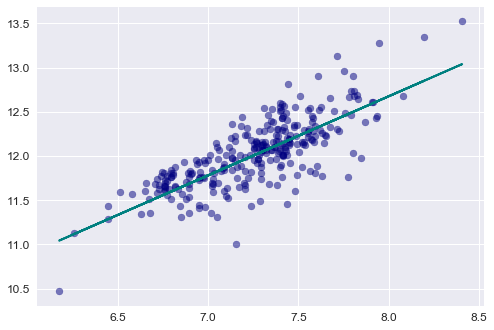

In [74]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X_train = trrev_train.GrLivArea.reshape((len(trrev_train.GrLivArea), 1))
y_train = trrev_train.SalePriceLog.reshape((len(trrev_train.SalePriceLog), 1))
X_test = trrev_test.GrLivArea.reshape((len(trrev_test.GrLivArea), 1))
y_test = trrev_test.SalePriceLog.reshape((len(trrev_test.SalePriceLog), 1))

# Create linear regression object
lm = linear_model.LinearRegression()

# Train the model using the training sets
model = lm.fit(X_train, y_train)

# Make predictions using the testing set
predictions = lm.predict(X_test)

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean Squared Error: %.2f"
      % mean_squared_error(y_test, predictions))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, predictions))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy', alpha=0.5)
plt.plot(X_test, predictions, color='teal', linewidth=2)

plt.show()

Coefficients: 
 [[ 0.0012239]]
Mean Squared Error: 0.09
R-squared: 0.42


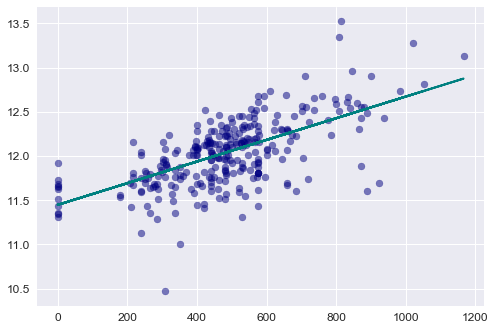

In [75]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X_train = trrev_train.GarageArea.reshape((len(trrev_train.GarageArea), 1))
y_train = trrev_train.SalePriceLog.reshape((len(trrev_train.SalePriceLog), 1))
X_test = trrev_test.GarageArea.reshape((len(trrev_test.GarageArea), 1))
y_test = trrev_test.SalePriceLog.reshape((len(trrev_test.SalePriceLog), 1))

# Create linear regression object
lm = linear_model.LinearRegression()

# Train the model using the training sets
model = lm.fit(X_train, y_train)

# Make predictions using the testing set
predictions = lm.predict(X_test)

# The coefficients
print('Coefficients: \n', lm.coef_)
# The mean squared error
print("Mean Squared Error: %.2f"
      % mean_squared_error(y_test, predictions))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, predictions))

# Plot outputs
plt.scatter(X_test, y_test,  color='navy', alpha=0.5)
plt.plot(X_test, predictions, color='teal', linewidth=2)

plt.show()